In [0]:
#src: https://github.com/suriyasingh/Self-supervision-for-segmenting-overhead-imagery/tree/master
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My\ Drive/DL\ Project/self-sup

/content/drive/My Drive/DL Project/self-sup


In [0]:
## import libraries
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from utils.dataloaders import context_inpainting_dataloader, segmentation_data_loader
from models import resnet18_encoderdecoder, resnet18_encoderdecoder_wbottleneck, resnet50_encoderdecoder
from models import resnet18_coach_vae
import torchvision

import warnings
warnings.filterwarnings('ignore')

## fix seeds
torch.cuda.manual_seed(7)
torch.manual_seed(7)
np.random.seed(7)

In [0]:
!pip install kornia
import kornia

     |████████████████████████████████| 163kB 2.8MB/s 


In [0]:
nClasses = 2
rec_weight = 0.99            ### loss = rec_weight*loss_rec+ (1-rec_weight)*loss_con

In [0]:
### Hard-coded Homography transform matrices
# 6 x 3 x 3: order same as camera CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, 􏰀CAM_BACK_RIGHT
M_matrices = torch.tensor([
    # CAM_FRONT_LEFT
    [[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
        [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
        [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]], 
    # CAM_FRONT
    [[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
        [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
        [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]],
    # CAM_FRONT_RIGHT
    [[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
        [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
        [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]],
    # CAM_BACK_LEFT
    [[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
        [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
        [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]],
    # CAM_BACK
    [[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
        [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
        [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]],
    # CAM_BACK_RIGHT
    [[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
        [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
        [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]]
        ])
### Hard-coded Homography transform matrices
# 6 x 3 x 3: order same as camera CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, 􏰀CAM_BACK_RIGHT
M_matrices = torch.tensor([
    # CAM_FRONT_LEFT
    [[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
        [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
        [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]], 
    # CAM_FRONT
    [[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
        [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
        [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]],
    # CAM_FRONT_RIGHT
    [[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
        [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
        [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]],
    # CAM_BACK_LEFT
    [[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
        [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
        [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]],
    # CAM_BACK
    [[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
        [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
        [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]],
    # CAM_BACK_RIGHT
    [[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
        [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
        [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]]
        ])

In [0]:
#modified: return masks as well
import random
import math

def _transform_input(input: torch.Tensor) -> torch.Tensor:
    r"""Reshape an input tensor to be (*, C, H, W). Accept either (H, W), (C, H, W) or (*, C, H, W).
    Args:
        input: torch.Tensor
    Returns:
        torch.Tensor
    """
    if not torch.is_tensor(input):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if len(input.shape) not in [2, 3, 4]:
        raise ValueError(
            f"Input size must have a shape of either (H, W), (C, H, W) or (*, C, H, W). Got {input.shape}")

    if len(input.shape) == 2:
        input = input.unsqueeze(0)

    if len(input.shape) == 3:
        input = input.unsqueeze(0)

    return input

def apply_erase_rectangles(input, params, random=True) -> torch.Tensor:
    """
    Generate a {0, 1} mask with drawed rectangle having parameters defined by params
    and size by input.size()
    0 - kept; 1 - erased => allow to stack & add up multiples masks

    Args:
        input (torch.Tensor): input image.
        params (Dict[str, torch.Tensor]):
            - params['widths']: widths tensor
            - params['heights']: heights tensor
            - params['xs']: x positions tensor
            - params['ys']: y positions tensor
            - params['values']: the value to fill in

    Returns:
        torch.Tensor: Erased image.
    """
    if not (params['widths'].size() == params['heights'].size() == params['xs'].size() == params['ys'].size()):
        raise TypeError(
            f"''rectangle params components must have same shape"
        )
    #torch.cuda.manual_seed(7)
    #torch.manual_seed(7)
    input = _transform_input(input)

    mask = torch.zeros(input.size()).type_as(input)
    values = torch.zeros(input.size()).type_as(input)

    widths = params['widths']
    heights = params['heights']
    xs = params['xs']
    ys = params['ys']
    vs = params['values']
    #print(input.size(0))
    if random: #random out xs, ys location in the reasonable range
      ys += torch.randint(-10,10,(input.size(0),))
      xs += torch.randint(-10,10,(input.size(0),))

    for i_elem in range(input.size()[0]):
        h = widths[i_elem].item()
        w = heights[i_elem].item()
        y = ys[i_elem].item()
        x = xs[i_elem].item()
        v = vs[i_elem].item()
        mask[i_elem, :, int(y):int(y + w), int(x):int(x + h)] = 1.
        values[i_elem, :, int(y):int(y + w), int(x):int(x + h)] = v
    transformed = torch.where(mask == 1., values, input)
    return transformed, mask


In [0]:
import kornia.augmentation as K

def random_masks(imgs):
  #6 deterministic masks: each tuple (w, h, x, y); 
  #center, same across 6 views 
  mask_agg = torch.zeros(imgs.shape).cuda()
  for y in [100,125,150]:
    for x in [100,120]:
      imgs, mask = apply_erase_rectangles(imgs, {'widths':torch.ones(imgs.size(0))*10, 'heights':torch.ones(imgs.size(0))*10, 
                                              'xs':torch.ones(imgs.size(0))*x, 'ys':torch.ones(imgs.size(0))*y,
                                              'values':torch.zeros(imgs.size(0))}, random=True)
      mask_agg += mask
  return imgs, mask_agg

def warp_transform_mask(imgs, M_matrices):
  '''
  input: tensor, size [batch_size, 6, 3, 256, 306]; for applying masks on 6 different views
  '''
  data, mask_list, masked = [], [],[]
  for i in range(6): #loop through each view
    img_batch = imgs[:,i,:,:,:].cuda()
    img_batch = kornia.warp_perspective(img_batch, M_matrices[i].unsqueeze(0).repeat(len(imgs), 1,1), dsize=(204, 306))
    img_batch = kornia.center_crop(img_batch, (192,288))
    data.append(img_batch.unsqueeze(0))
    img_masked, masks = random_masks(img_batch)
    masked.append(img_masked.unsqueeze(0))
    mask_list.append(masks.unsqueeze(0))
  return torch.cat(masked,dim=0),torch.cat(mask_list, dim=0), torch.cat(data,dim=0)  # #masked input, masks, target

In [0]:
#ours
from data_loading import get_loaders
train_loader, val_loader = get_loaders('unlabeled', batch_size = 2, visual=True)


In [0]:
sample = iter(train_loader).next()

In [0]:
BEV_masked, masks, target = warp_transform_mask(sample.cuda(), M_matrices)

In [0]:
masks.shape

torch.Size([6, 2, 3, 192, 288])

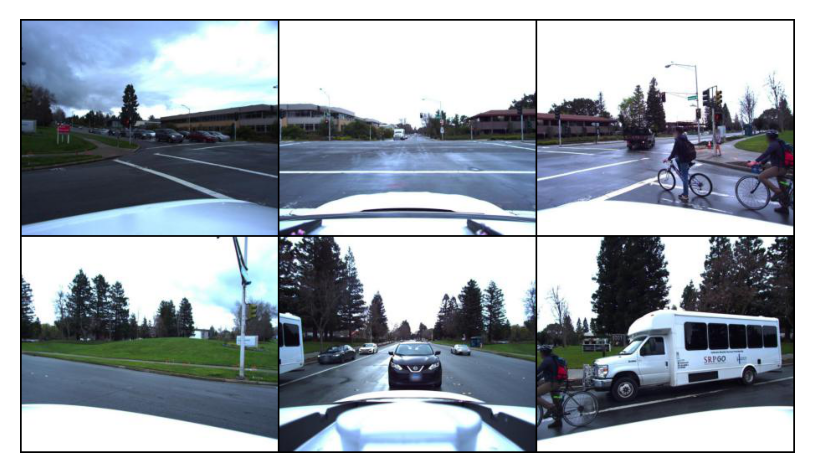

In [0]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200
plt.imshow(torchvision.utils.make_grid(sample[0].cpu(), nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


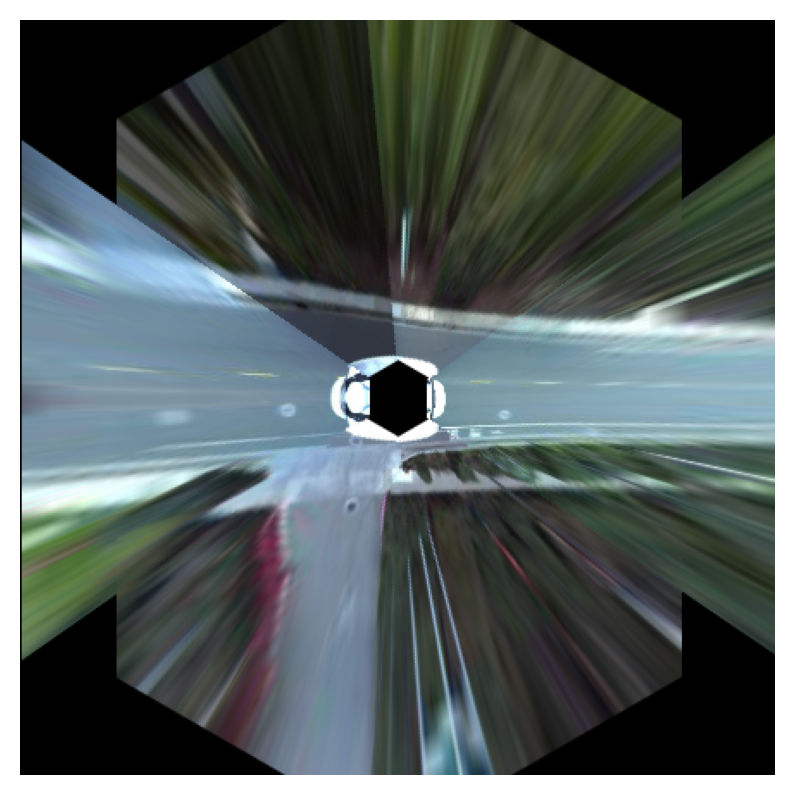

In [0]:
plt.imshow(inv_transform(sample_stitch[0,:,:,:]).cpu().numpy().transpose(1, 2, 0))
plt.axis('off');

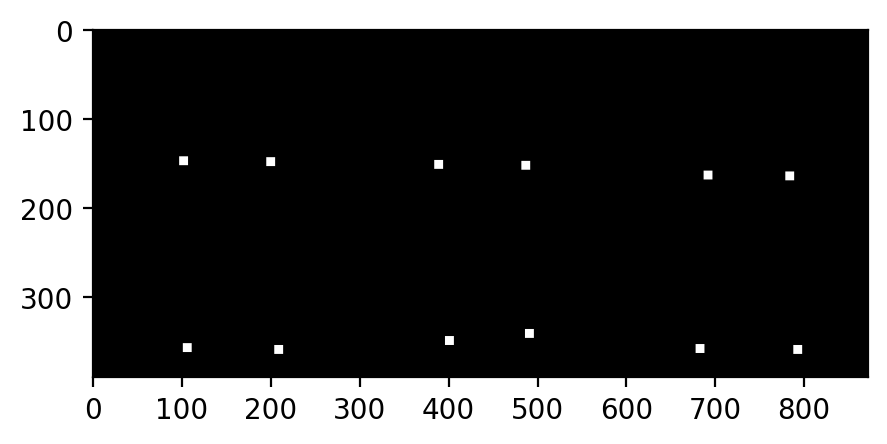

In [0]:
plt.imshow(torchvision.utils.make_grid(masks[:,1,:,:,:].cpu(), nrow=3).numpy().transpose(1, 2, 0))
#plt.imshow(inv_transform(BEV_masked[0,:,:,:]).cpu().numpy().transpose(1, 2, 0))
#plt.axis('off');

In [0]:
from models import ResNet_EncoderDecoder, BasicBlock
def resnet34_encoderdecoder(**kwargs):
    """Constructs a ResNet-34 encoder + decoder model.
    """
    model = ResNet_EncoderDecoder(BasicBlock, [3, 4, 6, 3], **kwargs)
    
    return model

In [0]:
#load trained net and continue training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#net = resnet50_encoderdecoder().cuda()
#net.load_state_dict(torch.load('resnet50_bs16'))# = torch.load('resnet50_bs16', map_location=device)

#net = resnet34_encoderdecoder().cuda() #
#net = torch.load('resnet34_pretrain_mask_round2', map_location=device) #continue training
#net = torch.load('resnet18_pretrain_mask', map_location=device) #continue training


In [0]:
#inverse back
from torchvision import transforms

inv_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = [1/0.339, 1/0.340, 1/0.342]), 
                                        transforms.Normalize(mean = [-0.548, -0.597, -0.630],
                                                             std = [1., 1., 1.])])

In [0]:
use_coach=False
net = resnet18_encoderdecoder().cuda() #resnet50_encoderdecoder().cuda() 
net_coach = None

if use_coach:
    net_coach = resnet18_coach_vae(drop_ratio=0.75).cuda()
    
net_optimizer = None
coach_optimizer = None
best_loss = 1e5
train_loss = []
val_loss = []
coach_loss = []

In [0]:
def train_context_inpainting(epoch, net, net_optimizer, M_matrices, M_rotations, M_flip):
    progbar = tqdm_notebook(total=len(train_loader), desc='Train')
    net.train()
    train_loss.append(0)
    for batch_idx, sample in enumerate(train_loader): #masks: 0 - kept (context), 1 - removed (rec)
        input_,mask_, target_ = stitch(sample.cuda(),M_matrices, M_rotations, M_flip, label=False, mask=True)
        
        net_optimizer.zero_grad() 
        #reconstruction loss
        outputs_1 = net(input_) #masked input
        mse_loss = (outputs_1 - target_)**2
        mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
        loss_rec = torch.sum(mse_loss*(mask_))/torch.sum(mask_) #erased masks value = 1 pixels
        #context loss
        outputs_2 = net(input_*mask_) #masked region pixels
        mse_loss = (outputs_2 - target_)**2
        mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
        loss_con = torch.sum(mse_loss*(1-mask_))/torch.sum(1-mask_) #masked pixels

        total_loss = rec_weight*loss_rec + (1-rec_weight)*loss_con
        total_loss.backward()

        net_optimizer.step()    
        train_loss[-1] += total_loss.data

    progbar.set_description('Train (loss=%.4f)' % (train_loss[-1]/(batch_idx+1)))
    progbar.update(1)
    train_loss[-1] = train_loss[-1]/len(train_loader)
    print('Epoch Train loss..', train_loss[-1])

        
def val_context_inpainting(iter_, epoch, net, M_matrices, M_rotations, M_flip):
    global best_loss
    progbar = tqdm_notebook(total=len(val_loader), desc='Val')
    net.eval()          
    val_loss.append(0)
    for batch_idx, sample in enumerate(val_loader):
        input_,mask_, target_ = stitch(sample.cuda(),M_matrices, M_rotations, M_flip, label=False, mask=True)
        outputs_1 = net(input_) #masked input
        mse_loss = (outputs_1 - target_)**2
        mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
        loss_rec = torch.sum(mse_loss*(mask_))/torch.sum(mask_) #Modified: masks 1 erased

        outputs_2 = net(input_*mask_) #masked region pixels
        mse_loss = (outputs_2 - target_)**2
        mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
        loss_con = torch.sum(mse_loss*(1-mask_))/torch.sum(1-mask_) #masked pixels

        total_loss = rec_weight*loss_rec + (1-rec_weight)*loss_con

        val_loss[-1] += total_loss.data
        progbar.set_description('Val (loss=%.4f)' % (val_loss[-1]/(batch_idx+1)))
        progbar.update(1)
        
    val_loss[-1] = val_loss[-1]/len(val_loader)
    if best_loss > val_loss[-1]:
        best_loss = val_loss[-1]
        print('Saving..')
        #state = {'net_segmentation': net_segmentation}
        #torch.save(net.state_dict(), 'resnet34_pretrain_mask')
        torch.save(net, 'resnet18_pretrain_mask_stitch')

In [0]:
use_coach_masks = False
epochs = []
lrs = []

if use_coach:
    epochs = [100, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
    lrs = [[1e-1, 1e-2, 1e-3, 1e-4],
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5],
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5]]
else:
    epochs = [5]
    lrs = [[1e-1, 1e-2, 1e-3, 1e-4]]

In [0]:
#!pip install ipywidgets
?warp_transform

In [0]:
#from ipywidgets import IntProgress
use_coach=False

#progbar_1 = tqdm_notebook(total=len(epochs), desc='Iters')
for iter_ in range(0, len(epochs)):
    best_loss = 1e5    
    
    if use_coach and iter_ > 0:
        use_coach_masks = True
        progbar_2 = tqdm_notebook(total=epochs[iter_], desc='Epochs')
        optimizer_coach = optim.Adam(net_coach.parameters(), lr=1e-5)
        
        for epoch in range(epochs[iter_]):
            train_coach(epoch, net=net, coach=net_coach, coach_optimizer=optimizer_coach)
            progbar_2.update(1)
    
    net_optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    
    progbar_2 = tqdm_notebook(total=epochs[iter_], desc='Epochs')
    for epoch in range(epochs[iter_]):
#         if epoch%10 == 0:
#             if use_coach:
#                 visualize_self_sup(cols = 4, net = net.eval(), coach = net_coach.eval(), use_coach_masks = use_coach_masks)
#             else:
#                 visualize_self_sup(cols = 4, net = net.eval(), coach = None, use_coach_masks = use_coach_masks)
                
        if epoch == 90:
            net_optimizer = optim.SGD(net.parameters(), lr=lrs[iter_][3], momentum=0.9, weight_decay=5e-4)
        if epoch == 80:
            net_optimizer = optim.SGD(net.parameters(), lr=lrs[iter_][2], momentum=0.9, weight_decay=5e-4)
        if epoch == 20:
            net_optimizer = optim.SGD(net.parameters(), lr=lrs[iter_][1], momentum=0.9, weight_decay=5e-4)
        if epoch == 0:
            net_optimizer = optim.SGD(net.parameters(), lr=lrs[iter_][0], momentum=0.9, weight_decay=5e-4)
    
        train_context_inpainting(epoch, net = net, net_optimizer=net_optimizer,M_matrices=M_matrices, M_rotations=M_rotations, M_flip=M_flip)
                                 
        val_context_inpainting(iter_, epoch, net = net,M_matrices=M_matrices, M_rotations=M_rotations, M_flip=M_flip)

        #progbar_2.update(1)
                
    #progbar_1.update(1)

RuntimeError: ignored

In [0]:
val_context_inpainting(iter_, epoch, net = net, coach=net_coach,M_matrices=M_matrices, use_coach_masks=use_coach_masks)

Saving..


In [0]:
for i in range(1,5):
  print('continue epoch...', i)
  train_context_inpainting(epoch, net = net, net_optimizer=net_optimizer,M_matrices=M_matrices, coach=net_coach, use_coach_masks=use_coach_masks)


continue epoch... 1
batch:  0.0
Train (loss=0.1439)
Saving..
continue epoch... 2
batch:  0.0
Train (loss=0.1151)
Saving..
continue epoch... 3
batch:  0.0
Train (loss=0.1481)
Saving..
continue epoch... 4
batch:  0.0
Train (loss=0.1276)
Saving..


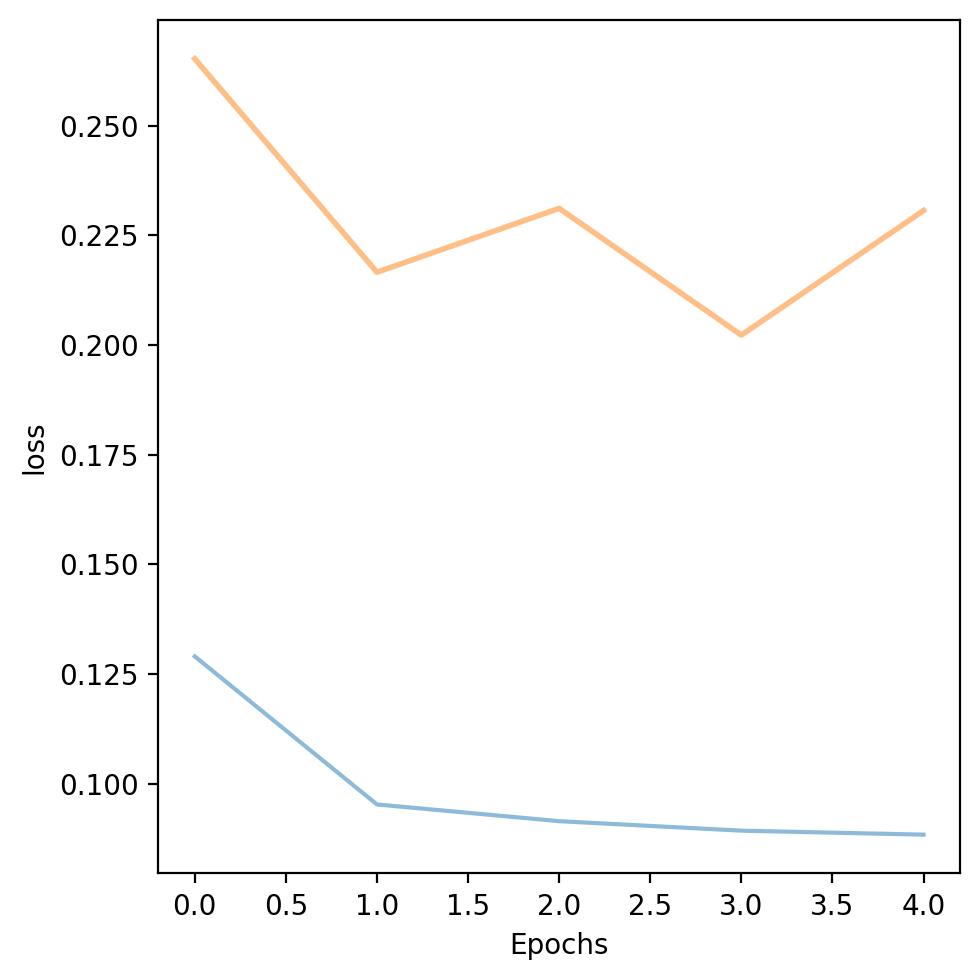

In [0]:
from utils.printing import training_curves_loss
training_curves_loss(train_loss, val_loss)

In [0]:
#del(net_coach)
#del(net)
torch.cuda.empty_cache()

___

### Semantic Segmentation

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = resnet50_encoderdecoder().cuda()
# ckpt_dict = torch.load('resnet50_bs16', map_location=device)
# net2.load_state_dict(ckpt_dict['model_state']) 

net.load_state_dict(torch.load('resnet50_bs16'))


<All keys matched successfully>

In [0]:
# from models import FCNify_v2, FCNify
# iter_ = len(epochs) - 1   ### iter_ = 0 is semantic inpainting model, iter_ > 0 is trained against coach masks
# #net = torch.load('resnet50_bs16') #torch.load(model_root + experiment + str(iter_) + '.ckpt.t7')['context_inpainting_net']
# net_segmentation = FCNify_v2(net, n_class = nClasses).cuda()
# optimizer_seg = None
# del(net)

In [0]:
import math
import copy
import torch
import torch.nn as nn
from torch.autograd import Variable

#src:https://github.com/suriyasingh/Self-supervision-for-segmenting-overhead-imagery/blob/c232438132cdbdd6a0bd68431c74ea52deb94240/models.py

class Multi_Classfier(nn.Module):
    def __init__(self, original_model, n_class=21, layers_to_remove=['classifier', 'tanh']):
        super(Multi_Classfier, self).__init__()
        torch.cuda.manual_seed(7)
        torch.manual_seed(7)
        for layers_ in layers_to_remove:        
            del(original_model._modules[layers_])
                
        self.features = copy.deepcopy(original_model)
        self.relu = nn.ReLU(inplace=True)
        self.d1 = nn.Conv2d(512, n_class, 1)
        self.d2 = nn.Conv2d(256, n_class, 1)
        self.d3 = nn.Conv2d(128, n_class, 1)
        self.d4 = nn.Conv2d(64, n_class, 1)
        self.d5 = nn.Conv2d(32, n_class, 1)

        self.up_maps = nn.ModuleList([nn.UpsamplingBilinear2d((800,800)) for i in range(5)])  #5 scales bilinear maps
        self.proj = nn.Linear(2048*6, 2048, bias=False) #might blow up

        ### initialize new layers with random weights
        for m in [self.d1,self.d2,self.d3,self.d4,self.d5]:
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

            
    def forward(self, x6):
    #in our case: x is BEV_inputs: size [6,bs,3,h,w]      
        agg = [] #store each view resnet encoder output
        for i in range(6):
        	x = self.features.conv1(x6[i])
        	x = self.features.bn1(x)
        	x = self.features.relu(x)
        	x = self.features.maxpool(x)
        	layer1 = self.features.layer1(x)
        	layer2 = self.features.layer2(layer1) #downsample 2^3
        	layer3 = self.features.layer3(layer2) #downsample 2^4
        	layer4 = self.features.layer4(layer3) #downsample 2^5
        	agg.append(layer4.unsqueeze(0))
        agg = torch.cat(agg,dim=0)
        agg = self.proj(agg.permute(1,3,4,2,0).reshape(len(x), 6,9, 2048*6))  #first reshpe to [bs,h,w,2048,6] then squeeze to [bs,h,w,2048*6]
        agg = agg.permute(0,3,1,2) #shape[bs, 2048, 6, 9]

        #decoding + classifier step
        d1 = self.features.relu(self.features.bn_d1(self.features.deconv1(layer4)))
        score_d1 = self.up_maps[0](self.d1(d1))
        d1 = self.features.relu(self.features.bn_d2(self.features.deconv2(d1)))
        score_d2 = self.up_maps[1](self.d2(d1))
        d1 = self.features.relu(self.features.bn_d3(self.features.deconv3(d1)))
        score_d3 = self.up_maps[2](self.d3(d1))
        d1 = self.features.relu(self.features.bn_d4(self.features.deconv4(d1)))
        score_d4 = self.up_maps[3](self.d4(d1))
        d1 = self.features.relu(self.features.bn_d5(self.features.deconv5(d1)))
        score_d5 = self.up_maps[4](self.d5(d1))
        #print(score_d1.shape, score_d2.shape, score_d3.shape, score_d4.shape, score_d5.shape)

        return score_d1 + score_d2 + score_d3 + score_d4 + score_d5

In [0]:
#from model_multi import Multi_Classfier
nClasses = 2
net_segmentation = Multi_Classfier(net, n_class = nClasses).cuda()
del(net)

In [0]:
from loss import soft_iou #similar to dice loss
from helper import collate_fn, compute_ts_road_map
from data_loading import get_loaders

from metric import fast_hist, performMetrics
from utils.dataloaders import segmentation_data_loader

In [0]:
train_seg_loss = []
val_seg_loss = []
train_seg_iou = []
val_seg_iou = []
ITER_SIZE = 1    ### accumulate gradients over ITER_SIZE iterations
best_iou = 0.

In [0]:
train_seg_loader, val_seg_loader = get_loaders('labeled', batch_size = 4, erase_count=0)


In [0]:
sample, target, road_image   = iter(val_seg_loader).next()

In [0]:
BEV_x = warp_transform(sample)
BEV_x.shape

torch.Size([6, 4, 3, 192, 288])

In [0]:
torch.stack(road_image).shape

torch.Size([8, 800, 800])

In [0]:
encoded_x = net.encode(BEV_x[0])
encoded_x.shape

torch.Size([4, 2048, 6, 9])

In [0]:
train_seg_loader = torch.utils.data.DataLoader(
    segmentation_data_loader(img_root = train_img_root, gt_root = train_gt_root, image_list = train_image_list_path+supervised_split+'.txt',
                             suffix=dataset, out=out, crop = True, crop_shape = [256, 256], mirror = True),
                                           batch_size=32, num_workers=8, shuffle = True)

val_seg_loader = torch.utils.data.DataLoader(
    segmentation_data_loader(img_root = val_img_root, gt_root = val_gt_root, image_list = val_image_list,
                             suffix=dataset, out=out, crop = False, mirror=False),
                                           batch_size=8, num_workers=8, shuffle = False)

In [0]:
def train_segmentation(epoch, net_segmentation, seg_optimizer):
    progbar = tqdm_notebook(total=len(train_seg_loader), desc='Train')
    loss = kornia.losses.DiceLoss()
    net_segmentation.train()
        
    train_seg_loss.append(0)
    seg_optimizer.zero_grad()
    hist = np.zeros((nClasses, nClasses))
    for batch_idx, data in enumerate(train_seg_loader):
      sample, target, road_image = data
      BEV_inputs = warp_transform(sample).cuda()
      road_image = torch.stack(road_image).long().cuda()
      outputs = net_segmentation(BEV_inputs)
      total_loss = loss(outputs, road_image) #(1 - soft_iou(outputs, road_image, ignore=ignore_class))/ITER_SIZE   
      total_loss.backward()
        
      #if (batch_idx%ITER_SIZE == 0 and batch_idx!=0) or batch_idx==len(train_loader)-1:
      seg_optimizer.step()
      seg_optimizer.zero_grad()
        
      train_seg_loss[-1] += total_loss.data
        
      _, predicted = torch.max(outputs.data, 1)
      # correctLabel = road_image.view(-1, targets.size()[1], targets.size()[2])
      # hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
      #                 predicted.view(predicted.size(0),-1).cpu().numpy(),
      #                 nClasses)
        
      # miou, p_acc, fwacc = performMetrics(hist)
        
      progbar.set_description('Train (loss=%.4f)' % (train_seg_loss[-1]/(batch_idx+1)))
      progbar.update(1)

    train_seg_loss[-1] = train_seg_loss[-1]/len(train_seg_loader)
    # miou, p_acc, fwacc = performMetrics(hist)
    # train_seg_iou += [miou]
    
    
def val_segmentation(epoch, net_segmentation):
    global best_score
    global val_score

    loss = kornia.losses.DiceLoss()
    progbar = tqdm_notebook(total=len(val_seg_loader), desc='Val')
    net_segmentation.eval()
        
    val_seg_loss.append(0)
    total = 0
    total_ts_road_map = 0
    with torch.no_grad():
      for batch_idx, data in enumerate(val_seg_loader):
        sample, target, road_image = data
        total += 1
        BEV_inputs = warp_transform(sample).cuda()
        road_image = torch.stack(road_image).long().cuda()
        outputs = net_segmentation(BEV_inputs)
        total_loss = loss(outputs, road_image) #(1 - soft_iou(outputs, road_image, ignore=ignore_class))/ITER_SIZE        
        #total_loss = 1 - soft_iou(outputs, targets, ignore=ignore_class)
        val_seg_loss[-1] += total_loss.data
        predicted_road_map = outputs.data.max(1)[1] # get the index of the max (no need to normalize)     
        ts_road_map = compute_ts_road_map(predicted_road_map, road_image)  
        #print(f'{i} - Road Map Score: {ts_road_map:.4}')		
        total_ts_road_map += ts_road_map
        progbar.set_description('Val (loss=%.4f, Score=%.4f)' % (val_seg_loss[-1]/(batch_idx+1), ts_road_map))
        progbar.update(1)
      val_seg_loss[-1] = val_seg_loss[-1]/len(val_seg_loader)
      val_score = total_ts_road_map / total
      print(f'Road Map Score: {total_ts_road_map / total:.4}')

      if best_score < val_score:
          best_score = val_score
          print('Saving..')
          #state = {'net_segmentation': net_segmentation}
          torch.save(net_segmentation.state_dict(), 'resnet50_seg')

In [0]:
progbar = tqdm_notebook(total=20, desc='Epochs')
for epoch in range(0, 100):
    if epoch == 90:
        seg_optimizer = optim.SGD(net_segmentation.parameters(), lr=1e-6, momentum=0.9, weight_decay=5e-4)
    elif epoch == 80:
        seg_optimizer = optim.SGD(net_segmentation.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-4)
    elif epoch == 10:
        seg_optimizer = optim.SGD(net_segmentation.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
    elif epoch == 0:
        seg_optimizer = optim.SGD(net_segmentation.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    
    train_segmentation(epoch, net_segmentation=net_segmentation, seg_optimizer=seg_optimizer)
    val_segmentation(epoch, net_segmentation=net_segmentation)
    progbar.update(1)

In [0]:
print(output.shape)

NameError: ignored

In [0]:
from utils.printing import segmentation_training_curves_loss, apply_color_map
segmentation_training_curves_loss(train_seg_loss, val_seg_loss, train_seg_iou, val_seg_iou)

In [0]:
del(net_segmentation)
torch.cuda.empty_cache()

In [0]:
c_map = np.asarray([[128, 128, 128], [128, 128, 0], [0, 64, 0], [0, 128, 0], [128, 0, 0], [0, 0, 0]])

In [0]:
def visualize_segmentation(net_segmentation):
    val_seg_loader = torch.utils.data.DataLoader(
    segmentation_data_loader(img_root = val_img_root, gt_root = val_gt_root, image_list = val_image_list,
                             suffix=dataset, out=out, crop = False, mirror=False),
                                           batch_size=1, num_workers=8, shuffle = False)
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(9, 9))
    for batch_idx, (inputs_, targets) in enumerate(val_seg_loader):
        inputs_, targets = Variable(inputs_.cuda()), Variable(targets.cuda())
            
        outputs = net_segmentation(inputs_)
        
        _, predicted = torch.max(outputs.data, 1)
        
        input_ = np.asarray(inputs_[0].cpu().numpy().transpose(1, 2, 0)+ mean_bgr[np.newaxis, np.newaxis, :], dtype=np.uint8)[:,:,::-1]
        axs[batch_idx, 0].imshow(input_)
        axs[batch_idx, 1].imshow(apply_color_map(targets[0].cpu().data, c_map))
        axs[batch_idx, 2].imshow(apply_color_map(predicted[0].cpu().data, c_map))
        if batch_idx == 3:
            break
     
    axs[0,0].set_title('input', fontsize=18)
    axs[0,1].set_title('GT', fontsize=18)
    axs[0,2].set_title('Pred', fontsize=18)
    fig.tight_layout()
    plt.show()
    

def evaluate_segmentation(net_segmentation):
    net_segmentation.eval()
    hist = np.zeros((nClasses, nClasses))
    val_seg_loader = torch.utils.data.DataLoader(
    segmentation_data_loader(img_root = val_img_root, gt_root = val_gt_root, image_list = val_image_list,
                             suffix=dataset, out=out, crop = False, mirror=False),
                                           batch_size=1, num_workers=8, shuffle = False)
    
    progbar = tqdm_notebook(total=len(val_seg_loader), desc='Eval')
        
    hist = np.zeros((nClasses, nClasses))
    for batch_idx, (inputs_, targets) in enumerate(val_seg_loader):
        inputs_, targets = Variable(inputs_.cuda()), Variable(targets.cuda())
            
        outputs = net_segmentation(inputs_)
        
        _, predicted = torch.max(outputs.data, 1)
        correctLabel = targets.view(-1, targets.size()[1], targets.size()[2])
        hist += fast_hist(correctLabel.view(correctLabel.size(0),-1).cpu().numpy(),
                        predicted.view(predicted.size(0),-1).cpu().numpy(),
                        nClasses)
        
        miou, p_acc, fwacc = performMetrics(hist)
        progbar.set_description('Eval (mIoU=%.4f)' % (miou))
        progbar.update(1)
        
    miou, p_acc, fwacc = performMetrics(hist)
    print('\n mIoU: ', miou)
    print('\n Pixel accuracy: ', p_acc)
    print('\n Frequency Weighted Pixel accuracy: ', fwacc)

In [0]:
net = torch.load(model_root + experiment + 'segmentation' + '.ckpt.t7')['net_segmentation'].cuda().eval() ### load the best model
evaluate_segmentation(net)

In [0]:
visualize_segmentation(net)

___